In [1]:
# %matplotlib notebook

from matplotlib import pylab
from astropy.coordinates import SkyCoord
import integralclient as ic

import time
import numpy as np

from astropy.table import Table, vstack
from astropy.io import fits
import glob
from scipy import stats
from astropy.time import Time

failed to get AUTH with env due to: 'K8S_SECRET_INTEGRAL_CLIENT_SECRET'
failed to get AUTH with homefile due to: [Errno 2] No such file or directory: '/home/savchenk/.secret-client-user'


In [2]:
RA=293.732
Dec=21.8967222
tstart_rel_mseconds=300.0
tstop_rel_seconds=300.0
t0_utc="2023-06-27T01:53:37.000" 
# t0_utc=Time(Time("2022-10-14T19:21:47").mjd - 8.632259375000002/24/3600, format='mjd').isot.replace(" ", "T") # hard x-ray
# t0_utc="2022-10-14T19:21:47"
# rt=1
# nrt=1
# arc=0
required_completeness=0.3
# mode="rt" # scw|rt|arc
mode="scw" # scw|rt|arc
global_snr_threshold=3.
negative_excesses=0

In [3]:
t0_utc

'2023-06-27T01:53:37.000'

In [4]:
if mode == "scw":
    rt=0
    nrt=1
    arc=0
elif mode == "rt":
    rt=1
    nrt=0
    arc=0
elif mode == "arc":
    rt=0
    nrt=0
    arc=1
elif mode == "flags":
    print("mode set by flags")
else:
    raise Exception("unknown mode: {}, allowed: scw, rt".format(mode))

In [5]:
source_coord = SkyCoord(RA, Dec, unit = "deg")

In [6]:
import importlib

In [7]:
# /home/savchenk/work/transients/workflows/integral-all-sky

import integralenv
importlib.reload(integralenv)

arc_root_prefix = integralenv.get_arc_root_prefix()

In [8]:
now_ijd = float(ic.converttime("UTC",time.strftime("%Y-%m-%dT%H:%M:%S"),"IJD"))
t0_ijd =  float(ic.converttime("UTC",t0_utc,"IJD"))

tstart_ijd = t0_ijd - tstart_rel_mseconds/24./3600
tstop_ijd = t0_ijd + tstop_rel_seconds/24./3600

now_ijd, t0_ijd, tstart_ijd, tstop_ijd

2023-06-27 22:55:34 v-think root[111965] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/UTC/2023-06-27T22:55:34/IJD
2023-06-27 22:55:35 v-think root[111965] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/UTC/2023-06-27T01:53:37.000/IJD


(8578.95605537037, 8578.079701203704, 8578.076228981481, 8578.083173425926)

In [9]:
lcs={}


In [10]:
def get_rtlc(t0_utc, tstop_rel_seconds):
    url = f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/integralhk/api/v1.0/rtlc/{t0_utc}/{tstop_rel_seconds}?json&prophecy"
    print("url:", url)
    r = requests.get(url)
    return np.array(r.json()['lc']['data'])

if nrt == 1:
    import isdcclient

    IC = isdcclient.ISDCClient()

    
    lcs['ACS'] = IC.genlc("ACS", t0_utc, "%.10lg"%max(tstart_rel_mseconds,tstop_rel_seconds),format='numpy')

    print("got lc from service of", lcs['ACS'])

    lcs['ACS'][:,1] = 0.05
    print("got ACS", lcs['ACS'])
    
    #lcs['IBIS/Veto'] = IC.genlc("IBIS_VETO", t0_utc, "%.10lg"%max(tstart_rel_mseconds,tstop_rel_seconds),format='numpy')
    #lcs['IBIS/Veto'][:,1] = 8.

import requests


if rt == 1:
    lc = get_rtlc(t0_utc, tstop_rel_seconds)
    lcs['ACS'] = np.vstack([lc[:,1], lc[:,1] * 0 + 0.05, lc[:,0]]).T

https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/integralhk/api/v1.0/genlc/ACS/2023-06-27T01:53:37.000/300
got lc from service of [[8.57807623e+03 4.00759745e-03 4.35000000e+03 6.51700401e+03]
 [8.57807623e+03 5.40068548e-02 4.13400000e+03 6.51705401e+03]
 [8.57807623e+03 1.04007998e-01 4.12800000e+03 6.51710401e+03]
 ...
 [8.57808317e+03 5.99854490e+02 4.15000000e+03 7.11685449e+03]
 [8.57808317e+03 5.99904489e+02 4.27800000e+03 7.11690449e+03]
 [8.57808317e+03 5.99954490e+02 4.20000000e+03 7.11695449e+03]]
got ACS [[8.57807623e+03 5.00000000e-02 4.35000000e+03 6.51700401e+03]
 [8.57807623e+03 5.00000000e-02 4.13400000e+03 6.51705401e+03]
 [8.57807623e+03 5.00000000e-02 4.12800000e+03 6.51710401e+03]
 ...
 [8.57808317e+03 5.00000000e-02 4.15000000e+03 7.11685449e+03]
 [8.57808317e+03 5.00000000e-02 4.27800000e+03 7.11690449e+03]
 [8.57808317e+03 5.00000000e-02 4.20000000e+03 7.11695449e+03]]


https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/integralhk/api/v1.0/genlc/ACS/2023-06-26T19:53:37.000/10
url: https://www.astro.unige.ch/mmoda/dispatch-data/gw/integralhk/api/v1.0/rtlc/2023-06-26T19:53:37.000/10?json&prophecy


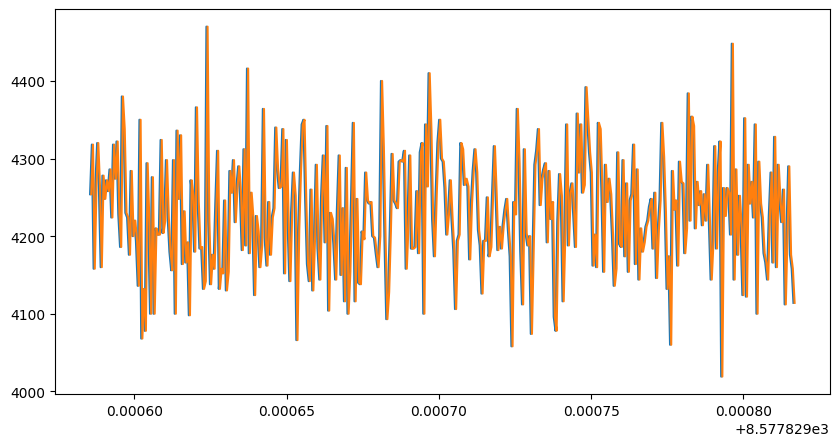

In [11]:
import isdcclient

IC = isdcclient.ISDCClient()

from astropy.time import Time

try:
    t_ref = Time(Time(t0_utc).mjd - 6/24, format='mjd').isot

    scwlc_ref = IC.genlc("ACS", t_ref, 10, format='numpy')
    rtlc_ref = get_rtlc(t_ref, 10)


    from matplotlib import pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(rtlc_ref[:,1], rtlc_ref[:,0], label="ACS RT")
    plt.plot(scwlc_ref[:,0], scwlc_ref[:,2], label="ACS")
    #TODO: for extra timing accuracy, extract here
except Exception as e:
    print("failed to get ref lc", e)

(-5.0, 5.0)

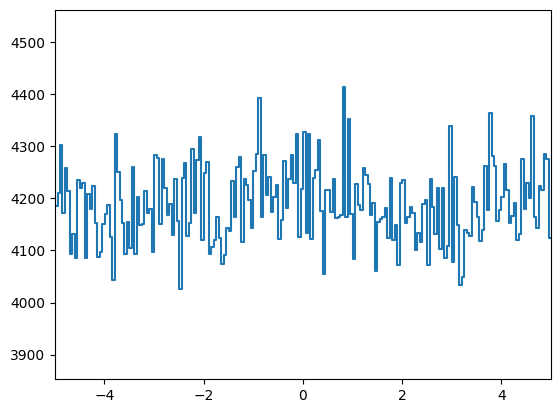

In [12]:
from matplotlib import pylab as plt

plt.figure()

plt.step(
    (lcs['ACS'][:,0] - t0_ijd)*24*3600,
    lcs['ACS'][:,2],
)

plt.xlim(-5,5)

In [13]:
def rebin(lc,n,av = False):
    if n == 0: return lc
    
    N=int(lc.shape[0]/n)*n
    if av:
        return lc[:N].reshape((int(lc.shape[0]/n), n)).mean(1)
    else:
        return lc[:N].reshape((int(lc.shape[0]/n), n)).sum(1)

In [14]:
import re
import time

# if rt == 1:

#     got_data = False
    
#     while not got_data:
#         current_rev=float(ic.converttime("UTC",t0_utc,"REVNUM"))

#         print("current rev", current_rev)

#         rtdata_roots=[
#             '/unsaved/astro/savchenk/dockers/realtimeacs/docker-ibas/spiacs-lcdump',
#             '/rtdata',
#             '/mnt/sshfs/isdc-in01//unsaved/astro/savchenk/dockers/realtimeacs/docker-ibas/spiacs-lcdump',    
#         ]

#         for realtime_dump_root in rtdata_roots + [ None ]:
#             #print("probing",realtime_dump_root,"with",glob.glob(realtime_dump_root+"/lcdump-revol-*.csv"))
#             if realtime_dump_root and len(glob.glob(realtime_dump_root+"/lcdump-revol-*.csv"))>0:
#                 print("this",realtime_dump_root)
#                 break

#         if not realtime_dump_root:
#             raise Exception("no realtime archvie found")

#         for rt_fn in reversed(sorted([l for l in glob.glob(realtime_dump_root+"/lcdump-revol-*.csv") if 
#                        float(re.search("lcdump-revol-(\d{4}).*.csv",l).groups()[0])<=current_rev+1])):

#             print(rt_fn)

#             rt_lc = np.genfromtxt(rt_fn)

#             lcs['ACS']=rt_lc[:,(3,0,2,0)]
#             lcs['ACS'][:,1] = 0.05

#             first_data = lcs['ACS'][:,0][0]
#             last_data = lcs['ACS'][:,0][-1]

#             print("now", now_ijd, 
#                   "first data in file", first_data, 
#                   "last data", last_data, 
#                   "requested", t0_ijd, 
#                   "have margin", (last_data-t0_ijd)*24*3600,"s",
#                   "data delay", (now_ijd-last_data)*24*3600,"s")       


#             if t0_ijd<first_data:
#                 print("data in the previous file")
#                 continue
                

#             print("margin",(last_data-now_ijd)*24*3600-tstop_rel_seconds*1.5 + 100)
#             if  (last_data-t0_ijd)*24*3600>tstop_rel_seconds*1.5 + 100:                            
#                 print("this margin is sufficient")
#                 got_data=True
#                 break
#             else:
#                 print("this margin is NOT sufficient, waiting")
#             #    if (now_ijd-last_data)*24*3600>1000:
#             #        raise RuntimeError('margin insufficent, data too old: no more hope')                

#                 time.sleep(30)
#                 break
        
            
            

    

In [15]:
# lcs['ACS']

lcs['ACS'][:,0].min()

8578.076229027865

total lc (12000, 4)
min -0.0034721758383966517
max 0.003471695486950921
expected telapse 600.0 telapse 599.9504825100303 ontime 600.0000000000001
size (12000, 4) (12000,)
requested scale 0.05
b_tb 0.05000000000000001
acceptable, will be 1 0.05000000000000001
rebinned to (12000,)
{'meanrate': 83670.04499999998, 'maxrate': 90599.99999999999, 'stdvar': 1475.4454687681052, 'meanerr': 1293.599976808905, 'excvar': 1.1405732028596527, 'maxsnr': 4.513652850197081, 'localfar': 0.03823229240413312, 'localfar_s': 2.0723555827478783}
requested scale 0.5
b_tb 0.05000000000000001
acceptable, will be 9 0.45000000000000007
rebinned to (1333,)
{'meanrate': 83669.91581228639, 'maxrate': 85857.77777777777, 'stdvar': 510.18095754048926, 'meanerr': 431.1996593801128, 'excvar': 1.183166420571665, 'maxsnr': 4.233411820001527, 'localfar': 0.015340994255169023, 'localfar_s': 2.424227440202622}
requested scale 1
b_tb 0.05000000000000001
acceptable, will be 19 0.9500000000000002
rebinned to (631,)
{'meanrate': 8

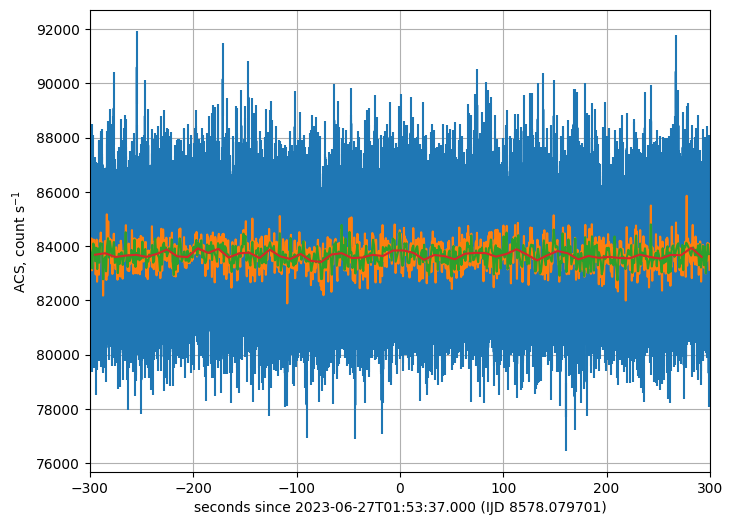

In [16]:
summary = dict()    

for n, lc in lcs.items():

    try:
        rel_s = (lc[:,0]-t0_ijd)*24*3600
    except:
        continue

    m = rel_s>-tstart_rel_mseconds
    m &= rel_s<tstop_rel_seconds

    print("total lc",lc.shape)
    print("min",lc[:,0].min()-t0_ijd)
    print("max",lc[:,0].max()-t0_ijd)

    lc = lc[m]

    b_tb = np.mean(lc[:,1])    

    rel_s = (lc[:,0]-t0_ijd)*24*3600

    expected_telapse = tstop_rel_seconds + tstop_rel_seconds    

    if len(rel_s) == 0:
        telapse = 0
        ontime = 0
    else:
        telapse = rel_s.max() - rel_s.min()
        ontime = np.sum(lc[:,1])


    print("expected telapse", expected_telapse, "telapse", telapse, "ontime", ontime)

    if float(ontime) / expected_telapse < required_completeness:
        raise Exception("data not available: exected %.5lg elapsed %.5lg ontime %.5lg completeness %s requireed %s"%(
            expected_telapse, telapse, ontime,
            ontime / expected_telapse, required_completeness))

    lc_summary = dict()
    summary[n.replace("/","_")]=lc_summary

    print("size", lc.shape, rel_s.shape)

    if np.sum(m) == 0: continue

    pylab.figure(figsize=(8,6))


    for ascale in [0.05, 0.5, 1, 10]:
        summary_scale = dict()
        lc_summary[('s_%.5lg'%ascale).replace(".","_")] = summary_scale        


        print("requested scale",ascale)
        print("b_tb",b_tb)

        if b_tb>ascale:
            ascale = b_tb


        nscale = int(ascale/b_tb)
        scale=nscale*b_tb

        print("acceptable, will be", nscale, scale)

        rate = rebin(lc[:,2],nscale,False)/scale
        rate_err = rebin(lc[:,2],nscale,False)**0.5/scale

        print("rebinned to",rate.shape)

        pylab.errorbar(
            rebin(rel_s,nscale,True),
            rate,
            rate_err,
            xerr=scale/4.
        )

        summary_scale['meanrate'] = np.mean(rate)
        summary_scale['maxrate'] = np.max(rate)
        summary_scale['stdvar'] = np.std(rate)
        summary_scale['meanerr'] = np.mean(rate_err**2)**0.5
        summary_scale['excvar'] = summary_scale['stdvar']/summary_scale['meanerr']        

        summary_scale['maxsnr'] = np.max((rate-np.mean(rate))/rate_err/summary_scale['excvar'])

        summary_scale['localfar'] = stats.norm.sf(summary_scale['maxsnr'])*rate.shape[0]

        summary_scale['localfar_s'] = stats.norm.isf(summary_scale['localfar']/2.) if summary_scale['localfar']<1 else 0

        # add FAR spike here

        if 'best' not in lc_summary or summary_scale['localfar_s'] > lc_summary['best']['localfar_s']:
            lc_summary['best'] = dict(
                localfar_s = summary_scale['localfar_s'],
                scale = ascale,
            )

        print(summary_scale)


    #tight_layout()
    pylab.grid()

    pylab.xlim(-tstart_rel_mseconds, tstop_rel_seconds)
    #pylab.axhspan(0,10,alpha=0.2,color="red")
    #pylab.axhspan(10,15,alpha=0.2,color="green")
    #pylab.axhspan(15,20,alpha=0.2,color="blue")
    pylab.ylabel(n+", count s$^{-1}$")
    #ylim([0,50])
    pylab.xlabel("seconds since %s (IJD %.10lg)"%(t0_utc, t0_ijd))

    fn=n.replace("/","_") + "_lc.png"
    pylab.savefig(fn)
    print("saving as",fn)
    break


In [17]:
# below S/N of 4 FAR is determined primarily by poisson, above - by spikes

def approx_FAR_spike_hz(snr, scale):    
    lim_snr = 2
    
    spike_rate_snr6 = 60./3600./24.
    if scale>=0.1:
        spike_rate_snr6*=(scale/0.1)**-1
    
    
    approx_FAR_hz = snr*0 + spike_rate_snr6 * (lim_snr/6.)**-2.7 
    
    try:
        if snr>lim_snr:
            approx_FAR_hz = spike_rate_snr6 * (np.abs(snr)/6.)**-2.7
    except:
        m=snr>lim_snr
        approx_FAR_hz[m] = (np.abs(snr[m])/6.)**-2.7 * spike_rate_snr6
        

    return approx_FAR_hz

def approx_FAR_norm_hz(snr, scale_s):
    return stats.norm.sf(snr)/scale_s

def approx_FAP(snr, t, scale_s):
    
    try:
        t_scaled = t[:]
        t_scaled[abs(t)<scale_s]=scale_s
    except:
        if abs(t)<scale_s:
            t_scaled=scale_s
        else:
            t_scaled=t

    approx_FAP = 2 * ( approx_FAR_norm_hz(snr, scale_s) + approx_FAR_spike_hz(snr, scale_s) )  * abs(t_scaled) * (1+np.log( 30/0.1))
    
    return approx_FAP



(1e-05, 30)

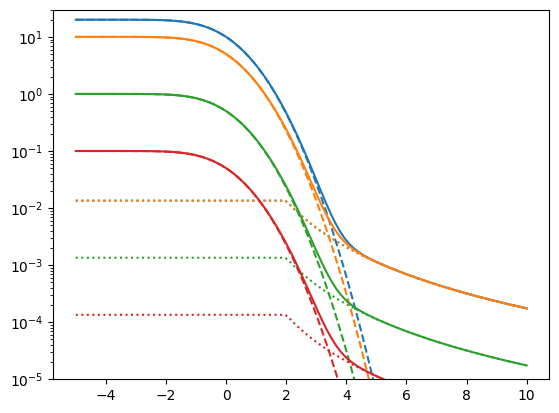

In [18]:
pylab.figure()

x=np.linspace(-5,10,100)

for scale_s in 0.05, 0.1, 1, 10:

    c=pylab.plot(x,approx_FAR_norm_hz(x, scale_s), ls='--')
    pylab.plot(x,approx_FAR_spike_hz(x, scale_s),c=c[0].get_color(),ls=":")
    pylab.plot(x,
               approx_FAR_spike_hz(x, scale_s) + approx_FAR_norm_hz(x, scale_s),
               c=c[0].get_color()
              )


    pylab.semilogy()

pylab.ylim([1e-5, 30])


In [19]:
timescales = sorted(set([0.05*ns for ns in sorted(set(
    list(map(int,np.logspace(0,np.log10(20*30),100))) 
))]  + list(np.linspace(1,31,30*2+1))))
timescales

[0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.8500000000000001,
 0.9,
 0.9500000000000001,
 1.0,
 1.1,
 1.1500000000000001,
 1.25,
 1.3,
 1.4000000000000001,
 1.5,
 1.6,
 1.7000000000000002,
 1.85,
 1.9500000000000002,
 2.0,
 2.1,
 2.25,
 2.4000000000000004,
 2.5,
 2.5500000000000003,
 2.7,
 2.9000000000000004,
 3.0,
 3.1,
 3.3000000000000003,
 3.5,
 3.5500000000000003,
 3.75,
 4.0,
 4.3,
 4.5,
 4.6000000000000005,
 4.9,
 5.0,
 5.2,
 5.5,
 5.550000000000001,
 5.95,
 6.0,
 6.3500000000000005,
 6.5,
 6.75,
 7.0,
 7.2,
 7.5,
 7.7,
 8.0,
 8.200000000000001,
 8.5,
 8.75,
 9.0,
 9.35,
 9.5,
 10.0,
 10.5,
 10.65,
 11.0,
 11.350000000000001,
 11.5,
 12.0,
 12.100000000000001,
 12.5,
 12.950000000000001,
 13.0,
 13.5,
 13.8,
 14.0,
 14.5,
 14.700000000000001,
 15.0,
 15.5,
 15.700000000000001,
 16.0,
 16.5,
 16.75,
 17.0,
 17.5,
 17.85,
 18.0,
 18.5,
 19.0,
 1

total lc (12000, 4)
min -0.0034721758383966517
max 0.003471695486950921
expected telapse 600.0 telapse 599.9504825100303 ontime 600.0000000000001
size (12000, 4) (12000,)
requested scale 0.05
true scale 0.05000000000000001
offset 0 rebinned to (12000,)
summary_scale['excvar'] 1.1405732028596527
908 4.513652850197081 -254.59595894208178
scale 0.05000000000000001 offset 0 found excesses 29
requested scale 0.1
true scale 0.10000000000000002
offset 0 rebinned to (6000,)
summary_scale['excvar'] 1.1573560141817287
5774 3.7001749238887114 277.42947088263463
scale 0.10000000000000002 offset 0 found excesses 13
offset 1 rebinned to (5999,)
summary_scale['excvar'] 1.1215253796715225
1285 3.5764065020135574 -171.4208899618825
scale 0.10000000000000002 offset 1 found excesses 10
requested scale 0.15000000000000002
true scale 0.15000000000000002
offset 0 rebinned to (4000,)
summary_scale['excvar'] 1.1410277290321529
3849 3.394609821317531 277.40447099204175
scale 0.15000000000000002 offset 0 found 

{'localfar_s': 3.235939701409979,
 'scale': 0.7000000000000001,
 'summary_scale': {'scale_s': 0.7000000000000002,
  'meanrate': 83670.05006675565,
  'maxrate': 85579.99999999999,
  'stdvar': 403.30636565401596,
  'meanerr': 345.72914680788494,
  'excvar': 1.1665385154180408,
  'maxsnr': 4.682586184914816,
  'maxsnr_t': 277.37947143447985,
  'localfar': 0.0012124299299278185,
  'localfar_s': 3.235939701409979,
  'excesses': [{'snr': 4.682586184914816,
    'rel_s_scale': 277.37947143447985,
    'rate': 85579.99999999999,
    'rate_err': 349.65288910166726,
    'rate_overbkg': 1909.9499332443374,
    'FAP': 0.728068976219474}]}}

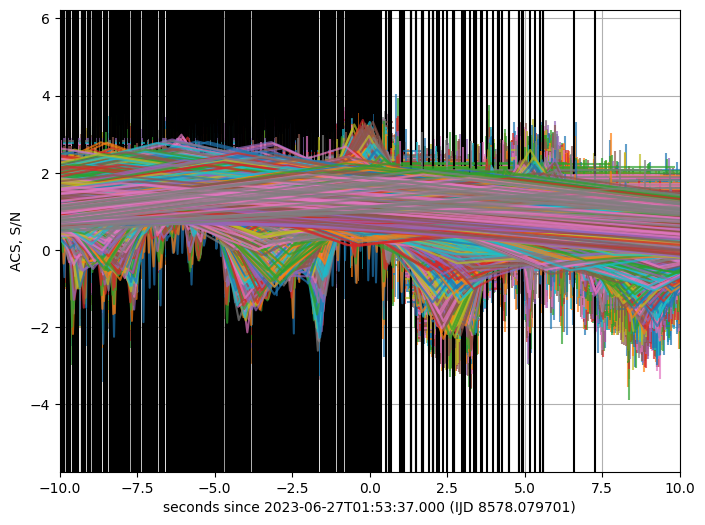

In [20]:
summary = dict()    
all_excesses=[]            

best_lc=None

for n, lc in lcs.items():
    
    #rel_s = lc[:,0]
    rel_s = (lc[:,0]-t0_ijd)*24*3600
    

    m = rel_s>-tstart_rel_mseconds
    m &= rel_s<tstop_rel_seconds
    
    print("total lc",lc.shape)
    print("min",lc[:,0].min()-t0_ijd)
    print("max",lc[:,0].max()-t0_ijd)
    
    lc = lc[m]
   # rel_s = lc[:,0]
    
    b_tb = np.mean(lc[:,1])    
    
    rel_s = (lc[:,0]-t0_ijd)*24*3600
    
    expected_telapse = tstop_rel_seconds + tstop_rel_seconds    
    
    if len(rel_s) == 0:
        telapse = 0
        ontime = 0
    else:
        telapse = rel_s.max() - rel_s.min()
        ontime = np.sum(lc[:,1])
        
    
    print("expected telapse", expected_telapse, "telapse", telapse, "ontime", ontime)
    
    if ontime / expected_telapse < required_completeness:
        raise Exception("data not available: exected %.5lg elapsed %.5lg ontime %.5lg"%(expected_telapse, telapse, ontime))
        
    lc_summary = dict()
    summary[n.replace("/","_")]=lc_summary
    
    print("size", lc.shape, rel_s.shape)
    
    if np.sum(m) == 0: continue
    
    pylab.figure(figsize=(8,6))
    
    best_lc_byscale={}

        
    
    #for ascale in [0.05, 0.1, 0.2, 0.5, 1, 2, 10]:
    for ascale in timescales:
    # for ascale in [0.05, 0.1, 0.5]:
    #for ascale in [0.05*i for i in range(20)] + [0.5*i for i in range(20)] + [15, 20, 25, 30]:
    #for ascale in [0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 1, 2, 8, 10]:
    #for ascale in [1,]:
        s_scale_mo = {}
        lc_summary[('s_%.5lg'%ascale).replace(".","_")] = s_scale_mo    
        
        
        print("requested scale",ascale)
#        print("b_tb",b_tb)
        
        if b_tb>ascale:
            ascale = b_tb
                    
        
        nscale = int(round(ascale/b_tb))
        scale=nscale*b_tb

        print("true scale", scale)
        
#        print("acceptable, will be", nscale, scale)
        
        c=None
        
        
        #for offset in range(0,nscale):            
        #for offset in (, round(nscale/2)):            
        
        if nscale < 20:
            offsets = range(0, round(nscale/2)+1)
        else:
            offsets = range(0, round(nscale/2)+1, max(round(round(nscale/2)/20), 1))
        
        for offset in offsets: 
            summary_scale = dict()
            s_scale_mo[offset]=summary_scale
            
            rel_s_scale = rebin(rel_s[offset:], nscale, True)
            rate = rebin(lc[offset:,2],nscale,False)/scale        
            rate_err = rebin(lc[offset:,2],nscale,False)**0.5/scale

            #print("rebinned to",rate.shape)
            print("offset", offset, "rebinned to",rate.shape)
            
            
            summary_scale['scale_s']=scale
            summary_scale['meanrate'] = np.mean(rate)
            summary_scale['maxrate'] = np.max(rate)            
            summary_scale['stdvar'] = np.std(rate)
            summary_scale['meanerr'] = np.mean(rate_err**2)**0.5
            summary_scale['excvar'] = summary_scale['stdvar']/summary_scale['meanerr']        

            print("summary_scale['excvar']", summary_scale['excvar'])

            if negative_excesses==1:
                snr = -(rate-np.mean(rate))/rate_err/summary_scale['excvar']
            else:
                snr = (rate-np.mean(rate))/rate_err/summary_scale['excvar']
            
            i_max = np.argmax(snr)
            
            print(i_max,snr[i_max],rel_s_scale[i_max])
            
            summary_scale['maxsnr'] = snr[i_max]
            summary_scale['maxsnr_t'] = rel_s_scale[i_max]

            summary_scale['localfar'] = stats.norm.sf(summary_scale['maxsnr'])*rate.shape[0]

            summary_scale['localfar_s'] = stats.norm.isf(summary_scale['localfar']/2.) if summary_scale['localfar']<1 else 0
            
            m_over_threshold = snr > global_snr_threshold
                        
            excesses = dict(
                            snr = snr[m_over_threshold],
                            rel_s_scale = rel_s_scale[m_over_threshold],
                            rate = rate[m_over_threshold],
                            rate_err = rate_err[m_over_threshold],
                            rate_overbkg = rate[m_over_threshold] - np.mean(rate),
                        )
                        
            summary_scale['excesses'] = [dict(zip(excesses.keys(), er)) for er in zip(*excesses.values())]

            for e in summary_scale['excesses']:
                e['FAP'] = approx_FAP(e['snr'], e['rel_s_scale'], scale)
            
            all_excesses+=[
                        dict(scale=scale, offset=offset,excess=e) for e in summary_scale['excesses']
                    ]

            print("scale", scale, "offset", offset, "found excesses",len(summary_scale['excesses']))                        

            #r=pylab.errorbar(
            #    rebin(rel_s[offset:],nscale,True),
            #    rate,
            #    rate_err,
            #    xerr=scale/4.,
            #    c=c,
            #    alpha=0.7
            #)
            
        #    print(rel_s_scale.shape, snr.shape)
            
            r = pylab.errorbar(
                rel_s_scale,
                snr,
                snr*0+1,
                xerr=scale/4.,
                c=c,
                alpha=0.7
            )
            
            pylab.axvline(summary_scale['maxsnr_t'],c="k")
            
            
            c=r[0].get_color()

            
            # add FAR spike here

            if 'best' not in lc_summary or summary_scale['localfar_s'] > lc_summary['best']['localfar_s']:
                lc_summary['best'] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                )
                best_lc=rel_s_scale,rate,rate_err
            
            if 'best' not in s_scale_mo or summary_scale['localfar_s'] > s_scale_mo['best']['localfar_s']:
                s_scale_mo['best'] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                )
              #  best_lc=rel_s_scale,rate,rate_err
            
            if ascale not in best_lc_byscale or summary_scale['localfar_s'] > best_lc_byscale[ascale]['localfar_s']:
                best_lc_byscale[ascale] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                    best_lc=(rel_s_scale,rate,rate_err),
                )
                
        
            #print(summary_scale)
        s_scale_mo.update(s_scale_mo['best']['summary_scale'])

    #tight_layout()
    pylab.grid()

    #pylab.xlim(-tstart_rel_mseconds, tstop_rel_seconds)
    #pylab.axhspan(0,10,alpha=0.2,color="red")
    #pylab.axhspan(10,15,alpha=0.2,color="green")
    #pylab.axhspan(15,20,alpha=0.2,color="blue")
    pylab.ylabel(n+", S/N")
    #ylim([0,50])
    pylab.xlabel("seconds since %s (IJD %.10lg)"%(t0_utc, t0_ijd))
    pylab.xlim([-10, 10])
    
    detfn=n.replace("/","_") + "_det_lc.png"
    pylab.savefig(detfn)
    print("saving as",detfn)
    
summary['ACS']['best']

(-200.0, 200.0)

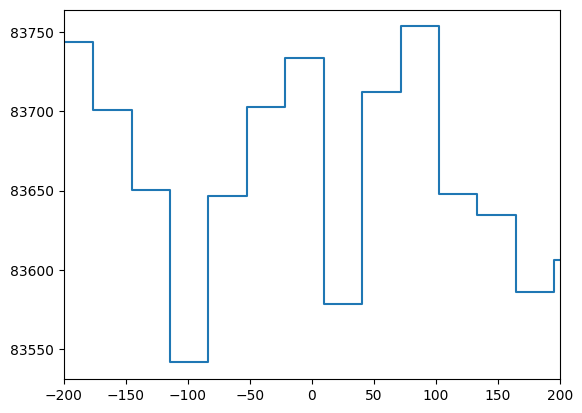

In [21]:
plt.figure()


snr = (rate-np.mean(rate))/rate_err/summary_scale['excvar']

plt.step(
    rel_s_scale,
    rate
)
plt.xlim(-200,200)
            

In [22]:
for e in all_excesses:
    if np.abs(e['scale'] - 0.05)< 0.001:
        # if np.abs(e['excess']['rel_s_scale']) < 5:
        print(e['excess']['rel_s_scale'], e)

-276.99597621685825 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 3.553574189193322, 'rel_s_scale': -276.99597621685825, 'rate': 89079.99999999999, 'rate_err': 1334.7658970770865, 'rate_overbkg': 5409.955000000002, 'FAP': 24.72281766732664}}
-254.59595894208178 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 4.513652850197081, 'rel_s_scale': -254.59595894208178, 'rate': 90599.99999999999, 'rate_err': 1346.105493637107, 'rate_overbkg': 6929.955000000002, 'FAP': 5.32986893828772}}
-246.79595048655756 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 3.374962183467937, 'rel_s_scale': -246.79595048655756, 'rate': 88799.99999999999, 'rate_err': 1332.6664999166144, 'rate_overbkg': 5129.955000000002, 'FAP': 35.29292259069915}}
-171.445890533505 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 4.237371802832207, 'rel_s_scale': -171.445890533505, 'rate': 90159.99999999999, 'rate_err': 1342.8328265275613, 'rate_overbkg': 6489.955000000002, '

In [23]:
grouped_excesses = []

for i in sorted(all_excesses, key=lambda x:x['excess']['FAP']):
    if i['excess']['FAP']<1 or True:
        print(i['scale'],i['offset'], i['excess']['snr'], i['excess']['rel_s_scale'], i['excess']['FAP'])
        
        grouped=False
        for g in grouped_excesses:
            if abs(i['excess']['rel_s_scale']-g['excess']['rel_s_scale'])<max(i['scale'],g['scale']):
                print("to group", g['excess']['rel_s_scale'])
                if i['excess']['snr'] > g['excess']['snr']:
                    print("group takeover")
                    g.update(i)
                grouped=True
                
        if not grouped:
            print("new group")
            #i['group']=[i]
            grouped_excesses.append(i)
        
    

2.4000000000000004 20 3.371209972036112 -0.22075170199968852 0.009432471324841697
new group
2.5500000000000007 10 3.3215023944403863 0.10424838914974209 0.010598310552641809
to group -0.22075170199968852
1.9500000000000004 14 3.319259403019904 0.004248323295122156 0.01065512456071971
to group -0.22075170199968852
2.5500000000000007 5 3.2770990404834848 -0.14575168161707766 0.01179711714639956
to group -0.22075170199968852
1.8500000000000003 15 3.2550703641887075 -0.4957518639433122 0.012453504330053206
to group -0.22075170199968852
2.4000000000000004 21 3.2422653845476397 -0.17075169816962443 0.012855324396962154
to group -0.22075170199968852
2.1000000000000005 14 3.222526747536417 -0.07075168209017388 0.013505477596462229
to group -0.22075170199968852
2.5500000000000007 8 3.215923957719478 0.004248352214584456 0.013731603587207417
to group -0.22075170199968852
1.3000000000000003 2 3.207635413432816 -0.2707518634941572 0.01402179895042604
to group -0.22075170199968852
2.550000000000000

In [24]:
grouped_excesses=sorted(grouped_excesses, key=lambda x:x['excess']['FAP'])

for i in grouped_excesses:
    print(f"timescale {i['scale']:4.2f}   S/N {i['excess']['snr']:5.2f}   T0+{i['excess']['rel_s_scale']:7.1f}   FAP {i['excess']['FAP']:7.5f}")

timescale 2.40   S/N  3.37   T0+   -0.2   FAP 0.00943
timescale 0.40   S/N  3.61   T0+  -24.6   FAP 0.34866
timescale 1.00   S/N  3.29   T0+  -56.4   FAP 0.64347
timescale 0.70   S/N  4.68   T0+  277.4   FAP 0.72807
timescale 0.30   S/N  3.49   T0+  -47.0   FAP 1.14618
timescale 0.40   S/N  3.32   T0+  -48.9   FAP 1.28419
timescale 0.50   S/N  4.11   T0+  242.9   FAP 1.39033
timescale 0.70   S/N  3.53   T0+  148.6   FAP 1.42961
timescale 0.50   S/N  3.35   T0+  114.4   FAP 2.24816
timescale 0.65   S/N  3.19   T0+ -116.1   FAP 2.64974
timescale 0.50   S/N  3.35   T0+  169.3   FAP 3.39110
timescale 0.05   S/N  4.24   T0+ -171.4   FAP 4.60269
timescale 0.05   S/N  4.51   T0+ -254.6   FAP 5.32987
timescale 0.05   S/N  3.63   T0+   74.8   FAP 5.54821
timescale 0.20   S/N  3.22   T0+   85.7   FAP 5.79387
timescale 0.05   S/N  4.41   T0+  267.0   FAP 6.06134
timescale 0.10   S/N  3.45   T0+   88.0   FAP 7.02210
timescale 0.20   S/N  3.30   T0+  127.8   FAP 7.19188
timescale 0.05   S/N  3.81  

In [25]:
import json

len(json.dumps(grouped_excesses))

10962

In [26]:
summary['ACS']['best']

{'localfar_s': 3.235939701409979,
 'scale': 0.7000000000000001,
 'summary_scale': {'scale_s': 0.7000000000000002,
  'meanrate': 83670.05006675565,
  'maxrate': 85579.99999999999,
  'stdvar': 403.30636565401596,
  'meanerr': 345.72914680788494,
  'excvar': 1.1665385154180408,
  'maxsnr': 4.682586184914816,
  'maxsnr_t': 277.37947143447985,
  'localfar': 0.0012124299299278185,
  'localfar_s': 3.235939701409979,
  'excesses': [{'snr': 4.682586184914816,
    'rel_s_scale': 277.37947143447985,
    'rate': 85579.99999999999,
    'rate_err': 349.65288910166726,
    'rate_overbkg': 1909.9499332443374,
    'FAP': 0.728068976219474}]}}

In [27]:
#T

In [28]:
summary['ACS']['s_8']

{0: {'scale_s': 8.000000000000002,
  'meanrate': 83670.04499999998,
  'maxrate': 84002.62499999999,
  'stdvar': 122.41032711063774,
  'meanerr': 102.26805769642833,
  'excvar': 1.196955626887914,
  'maxsnr': 2.711543918283872,
  'maxsnr_t': 111.97933794075652,
  'localfar': 0.25114000736737363,
  'localfar_s': 1.147584800546106,
  'excesses': []},
 'best': {'localfar_s': 1.1527018826795772,
  'scale': 8.0,
  'summary_scale': {'scale_s': 8.000000000000002,
   'meanrate': 83670.11993243243,
   'maxrate': 83999.37499999999,
   'stdvar': 121.26304513132789,
   'meanerr': 102.26810349055098,
   'excvar': 1.1857367154807161,
   'maxsnr': 2.709886905385465,
   'maxsnr_t': -150.02087313401717,
   'localfar': 0.24903276843601782,
   'localfar_s': 1.1527018826795772,
   'excesses': []}},
 4: {'scale_s': 8.000000000000002,
  'meanrate': 83670.00675675675,
  'maxrate': 83954.99999999999,
  'stdvar': 123.11943822650873,
  'meanerr': 102.26803432448767,
  'excvar': 1.203889749517052,
  'maxsnr': 2.3

In [29]:
excvar_summary=dict(
)

for k,s in summary['ACS'].items():
    if 'scale_s' in s:
        print("%.5lg"%s['scale_s'], "%5.4lg"%s['excvar'])
        
        if s['scale_s']<=0.200:
            kg='hf_200ms'
        elif s['scale_s']<=2.00:
            kg='mf_200ms_2s'
        elif s['scale_s']<=10.00:
            kg='mf_2s_10s'
        else:
            kg='lf_10s'
        
        if kg not in excvar_summary:
            excvar_summary[kg]=[s['excvar']]
        else:
            excvar_summary[kg]+=[s['excvar']]

for k,v in excvar_summary.items():
    print(k,min(v),max(v))

0.05 1.141
0.1 1.157
0.15  1.14
0.2 1.154
0.25 1.149
0.3 1.156
0.35  1.15
0.4 1.165
0.45 1.183
0.5 1.176
0.55  1.19
0.6 1.196
0.65 1.203
0.7 1.167
0.75 1.201
0.8 1.215
0.85 1.241
0.9 1.194
0.95 1.207
1 1.193
1.1 1.179
1.15 1.192
1.25  1.23
1.3 1.196
1.4 1.202
1.5 1.217
1.6 1.221
1.7 1.227
1.85 1.197
1.95 1.216
2 1.242
2.1 1.198
2.25 1.243
2.4 1.216
2.5 1.235
2.55  1.18
2.7 1.222
2.9 1.222
3 1.276
3.1 1.228
3.3 1.219
3.5 1.189
3.55 1.231
3.75 1.233
4  1.17
4.3 1.184
4.5 1.261
4.6 1.251
4.9 1.293
5  1.24
5.2 1.252
5.5 1.213
5.55 1.265
5.95 1.189
6 1.186
6.35 1.172
6.5 1.205
6.75 1.217
7  1.19
7.2 1.251
7.5 1.302
7.7 1.128
8 1.186
8.2 1.148
8.5 1.158
8.75 1.281
9 1.216
9.35  1.28
9.5 1.232
10 1.269
10.5 1.151
10.65 1.226
11 1.199
11.35 1.275
11.5 1.254
12 1.239
12.1 1.223
12.5 1.235
12.95 1.352
13 1.393
13.5 1.081
13.8 1.192
14 1.282
14.5 1.164
14.7  1.29
15 1.245
15.5 1.294
15.7 1.283
16 1.306
16.5  1.32
16.75 1.388
17 1.233
17.5 1.351
17.85 1.249
18 1.222
18.5 1.458
19 1.313
19.05 1.313

total lc (12000, 4)
min -0.0034721758383966517
max 0.003471695486950921
{'scale': 2.4000000000000004, 'offset': 20, 'excess': {'snr': 3.371209972036112, 'rel_s_scale': -0.22075170199968852, 'rate': 84438.74999999999, 'rate_err': 187.57081995875583, 'rate_overbkg': 768.8688085675967, 'FAP': 0.009432471324841697}}
(-2.0, 2.0)
total lc (12000, 4)
min -0.0034721758383966517
max 0.003471695486950921
{'scale': 2.4000000000000004, 'offset': 20, 'excess': {'snr': 3.371209972036112, 'rel_s_scale': -0.22075170199968852, 'rate': 84438.74999999999, 'rate_err': 187.57081995875583, 'rate_overbkg': 768.8688085675967, 'FAP': 0.009432471324841697}}
(-2.0, 2.0)
total lc (12000, 4)
min -0.0034721758383966517
max 0.003471695486950921
{'scale': 2.4000000000000004, 'offset': 20, 'excess': {'snr': 3.371209972036112, 'rel_s_scale': -0.22075170199968852, 'rate': 84438.74999999999, 'rate_err': 187.57081995875583, 'rate_overbkg': 768.8688085675967, 'FAP': 0.009432471324841697}}
(-2.0, 2.0)
{'scale': 0.4000000000

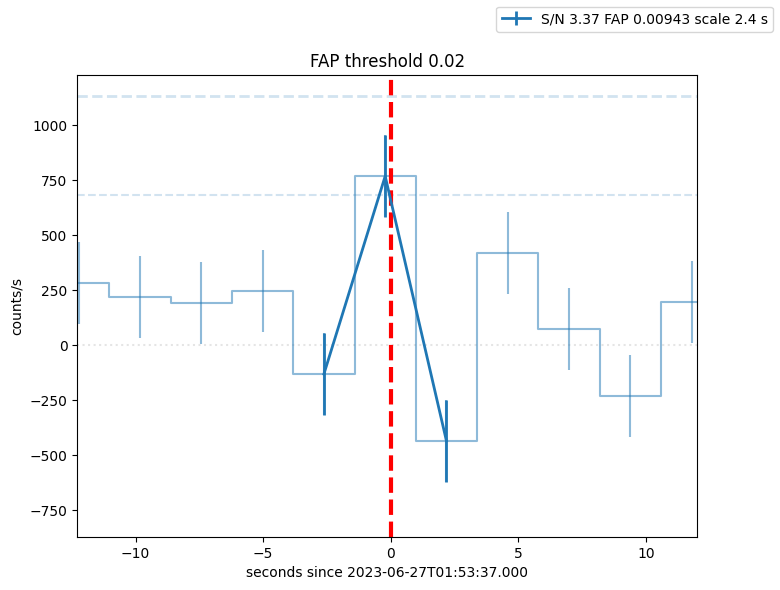

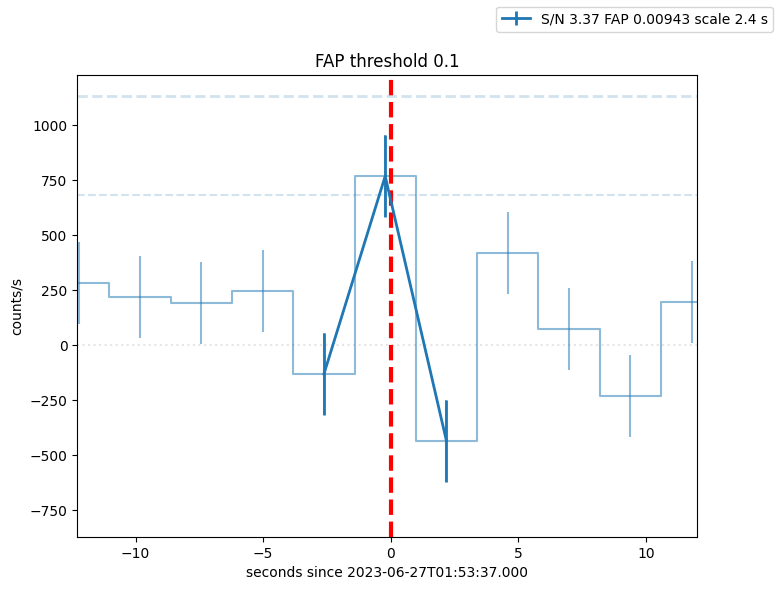

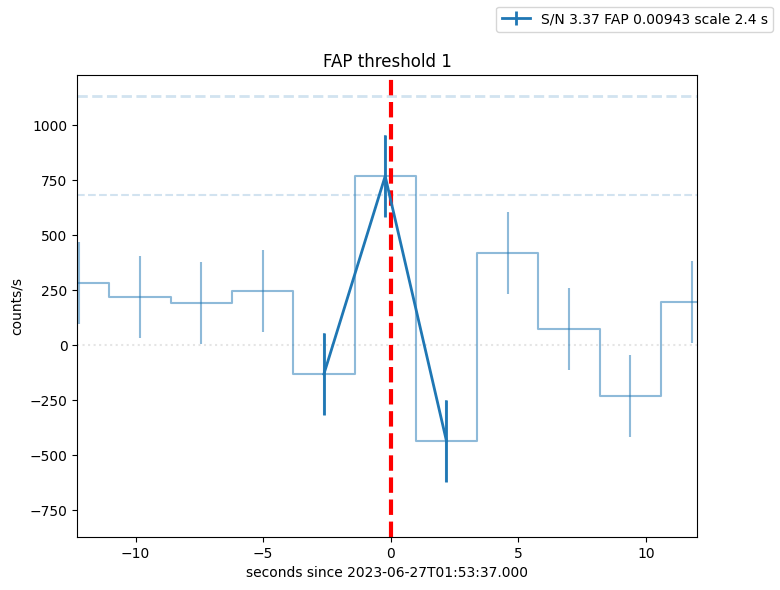

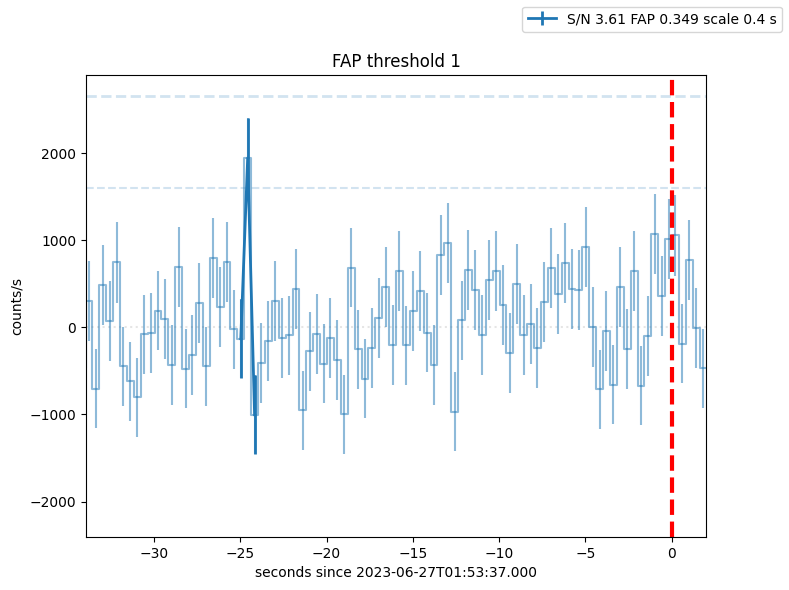

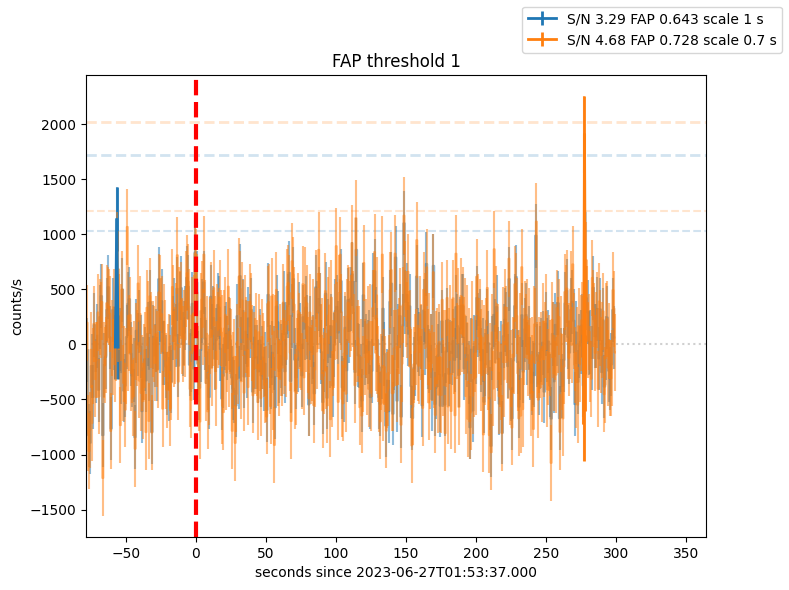

In [30]:
fig_names=[]


for limit_group in 0.02, 0.1, 1: 
    figs=dict()

    for n, lc in lcs.items():
        rel_s = (lc[:,0]-t0_ijd)*24*3600

        m = rel_s>-tstart_rel_mseconds
        m &= rel_s<tstop_rel_seconds

        print("total lc",lc.shape)
        print("min",lc[:,0].min()-t0_ijd)
        print("max",lc[:,0].max()-t0_ijd)

        lc = lc[m]
        rel_s = rel_s[m]

        for excess in grouped_excesses:
            #if excess['excess']['FAP'] > 0.02: continue
            if excess['excess']['FAP'] > limit_group: continue

            print(excess)


            offset = excess['offset']
            nscale = int(excess['scale']/b_tb)  
            scale=excess['scale']

            s_figs = sorted(figs.items(), key=lambda x:abs(x[0]-scale))

            if len(s_figs) == 0 or s_figs[0][0] < scale*0.5 or s_figs[0][0] > scale*1.5: 
                fig = pylab.figure(figsize=(8,6))
                figs[scale] = fig
                pylab.xlim([-2,2])
                pylab.xlabel("seconds since "+t0_utc)
                pylab.ylabel("counts/s")
                pylab.title("FAP threshold %.5lg"%limit_group)
            else:            
                print("good match", s_figs[0][0], scale)
                pylab.figure(s_figs[0][1].number)
                pylab.xlabel("seconds since "+t0_utc)
                pylab.ylabel("counts/s")



            rel_s_scale = rebin(rel_s[offset:],nscale,True)
            rate = rebin(lc[offset:,2],nscale,False)/scale        
            rate_err = rebin(lc[offset:,2],nscale,False)**0.5/scale

            bkg=np.mean(rate)

            m_on = np.abs(rel_s_scale-excess['excess']['rel_s_scale'])<excess['scale']*1.5


            pylab.grid(False)

            pylab.axhline(0, alpha=0.2, ls=":", color='gray')

            cr=pylab.errorbar(
                    rel_s_scale, 
                    (rate-bkg), 
                    (rate_err),
                    alpha=0.5,
                    ls="",
                )[0].get_color()

            pylab.step(
                    rel_s_scale, 
                    (rate-bkg), 
              #      (rate_err),
                    alpha=0.5,
                    where="mid",
                    c=cr,
                )

            pylab.axhline(np.std(rate)*3, alpha=0.2, ls="--",c=cr)
            pylab.axhline(np.std(rate)*5, alpha=0.2, ls="--", lw=2,c=cr)






            pylab.errorbar(
                    rel_s_scale[m_on], 
                    (rate-bkg)[m_on], 
                    (rate_err)[m_on],
                    lw=2.,
                    alpha=1,
                    label="S/N %.3lg FAP %.3lg scale %.3lg s"%(excess['excess']['snr'],excess['excess']['FAP'],excess['scale']),
                    c=cr
                )



            newlim=([
                min([excess['excess']['rel_s_scale']*1.3-excess['scale']*5,-excess['scale']*5]),
                max([excess['excess']['rel_s_scale']*1.3+excess['scale']*5,excess['scale']*5]),
            ])

            oldlim=pylab.gca().get_xlim()

            print(oldlim)

            pylab.xlim([
                min([oldlim[0],newlim[0]]),
                max([oldlim[1],newlim[1]]),
            ])


    for f_i,(s,f) in enumerate(figs.items()):
        f.legend()
        f.gca().axvline(0,ls="--",c="r",lw=3)
        fn="excess_%.5lg_%i.png"%(s,len(fig_names))
        f.savefig(fn)
        fig_names.append(fn)






axes [<Axes: > <Axes: > <Axes: > <Axes: > <Axes: >] <class 'numpy.ndarray'>


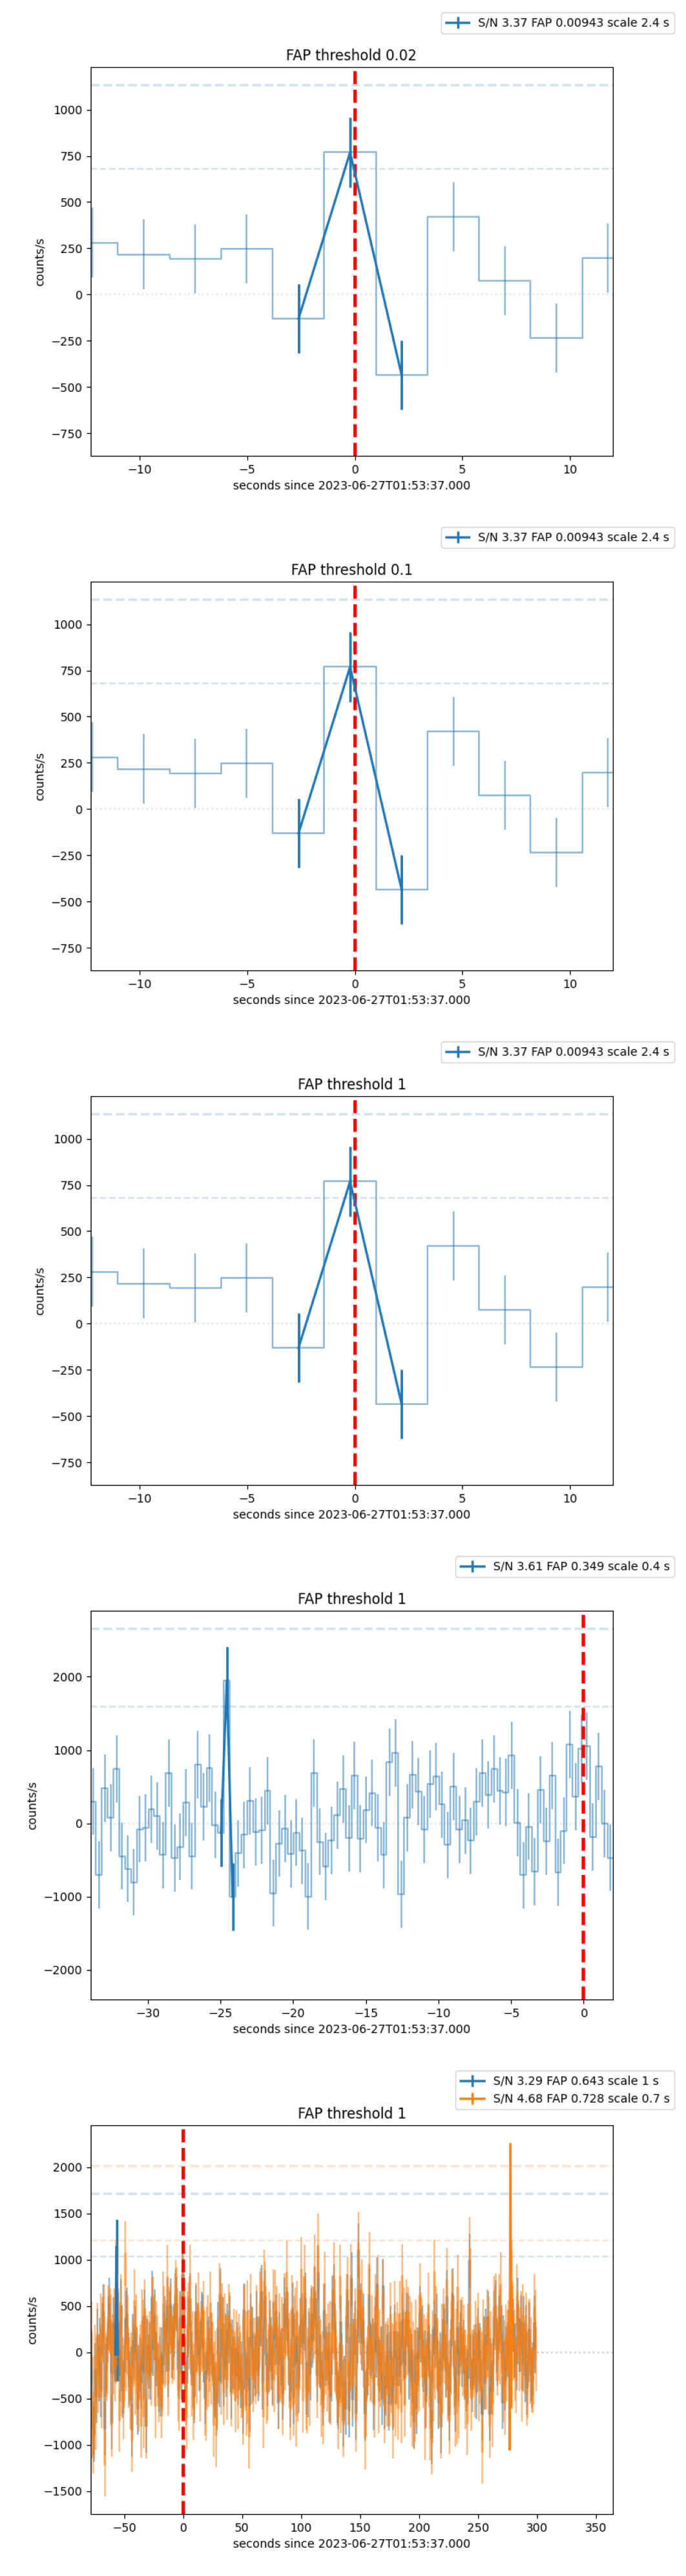

In [31]:
cols=1
rows=int(np.ceil(len(fig_names)/cols))


if rows>0:
    f, axes=pylab.subplots(rows, cols, figsize=(12, 8*rows))
    print("axes",axes,axes.__class__)

    if rows>1:
        axes=axes.flatten()
    else:
        axes=[axes]

    for i,fn in enumerate(fig_names):
        #f.add_subplot(len(fig_names), 2, i+1)
        axes[i].axis('off')
        axes[i].imshow(pylab.imread(fn) ) #, extent=(0,1,0,1))
        #pylab.imshow(pylab.imread(fn), extent=(0,1,(i-1)/len(fig_names),i/len(fig_names)))

    f.tight_layout()
else:
    f=pylab.figure()

f.savefig("excesses_mosaic.png")

In [32]:
if rt == 1:    
    summary['ACS_rt'] = summary['ACS']

In [33]:
summary['ACS']['s_1']['meanerr']

289.2572348502084

In [34]:
import json

json.dump(dict(
    summary=summary,
    reportable_excesses=grouped_excesses,
    excvar_summary=excvar_summary
), open("integral_all_sky.json","w"), indent=4)

In [35]:
acs_lc_png="ACS_lc.png"
acs_rt_lc_png="ACS_lc.png"
acs_rt_det_lc_png="ACS_det_lc.png"
ibis_veto_lc_png="IBIS_Veto_lc.png"
excesses_mosaic_png="excesses_mosaic.png"
summary=summary
reportable_excesses=grouped_excesses
excvar_summary=excvar_summary